<a href="https://colab.research.google.com/github/NatBrian/mediapipe-hand-recognition/blob/main/notebooks/point_history_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Point History Classification – Dynamic Hand Gesture Recognition (Mediapipe)

## 1. Project Overview

This notebook trains and explains a **Point History Classifier** for **hand gestures** using data collected from a Mediapipe-based application.

Instead of using all 21 hand keypoints, we use the **time history of a single fingertip point** (e.g. index finger) over several frames. This captures **dynamic gestures** such as “circle”, “up–down”, “left–right”, etc. as short 2D trajectories.

In [ ]:
import csv
import datetime
import os

import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For nicer plots in notebooks
%matplotlib inline

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("TensorFlow version:", tf.__version__)

def get_timestamped_filename(base_path, extension):
    """
    Generate a timestamped filename to prevent overwriting existing files.
    """
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    base_name = os.path.splitext(os.path.basename(base_path))[0]
    directory = os.path.dirname(base_path)
    return os.path.join(directory, f"{base_name}_{timestamp}{extension}")


TensorFlow version: 2.19.1


In [ ]:
# 2. Paths and Configuration

# CSV dataset created by the Mediapipe-based point history collector
dataset = '../data/point_history.csv'

# Base paths for saving models (we will append timestamps)
base_model_save_path = '../models/point_history/point_history_classifier.keras'
model_save_path = get_timestamped_filename(base_model_save_path, '.keras')

base_tflite_save_path = '../models/point_history/point_history_classifier.tflite'
tflite_save_path = get_timestamped_filename(base_tflite_save_path, '.tflite')

# 2.2 Input structure: point history over time
TIME_STEPS = 16   # number of time steps in the history
DIMENSION = 2     # 2D point: (x, y) per time step
INPUT_DIM = TIME_STEPS * DIMENSION  # flattened length = 32


## 2. Dataset Loading and Basic Understanding

We assume the dataset `point_history.csv` has been generated by a **Mediapipe** application that records the motion history of a single hand point (e.g. fingertip).

**CSV format assumption (per row):**

- Column 0: integer **gesture label** (0, 1, 2, 3).
- Columns 1–32: **flattened point history** of length 32:
  - 16 time steps × 2 coordinates (x, y):
  $[x_1, y_1, x_2, y_2, \dots, x_{16}, y_{16}]$

Each row therefore represents **one dynamic gesture sample**.


In [ ]:
# 2.3 Load dataset from CSV

X_dataset = np.loadtxt(
    dataset,
    delimiter=',',
    dtype='float32',
    usecols=list(range(1, INPUT_DIM + 1))  # columns 1..32
)

y_dataset = np.loadtxt(
    dataset,
    delimiter=',',
    dtype='int32',
    usecols=(0,)  # column 0 = label
)

# Classification settings
labels = np.unique(y_dataset)
NUM_CLASSES = len(labels) # number of gesture classes
print("Gesture classes:", labels)
print("NUM_CLASSES:", NUM_CLASSES)

print("X_dataset shape:", X_dataset.shape)  # (N, 32)
print("y_dataset shape:", y_dataset.shape)  # (N,)

print("First 3 samples (features):")
print(X_dataset[:3])

print("First 3 labels:", y_dataset[:3])


Gesture classes: [0 1 2 3 4]
NUM_CLASSES: 5
X_dataset shape: (5676, 32)
y_dataset shape: (5676,)
First 3 samples (features):
[[ 0.          0.         -0.00208333 -0.0037037  -0.00208333 -0.0037037
  -0.003125   -0.00555556 -0.00208333 -0.00740741 -0.00208333 -0.00925926
  -0.00104167 -0.01111111 -0.00208333 -0.01481481 -0.003125   -0.01481481
  -0.003125   -0.01666667 -0.003125   -0.01481481 -0.003125   -0.01666667
  -0.00208333 -0.01851852 -0.00208333 -0.01666667 -0.00104167 -0.01666667
   0.         -0.01481481]
 [ 0.          0.          0.00104167  0.          0.00208333  0.
   0.00104167  0.00185185  0.00208333  0.00185185  0.00208333  0.00185185
   0.00208333  0.00185185  0.003125    0.          0.003125    0.00185185
   0.003125    0.          0.          0.00185185 -0.00104167  0.0037037
  -0.00104167  0.0037037  -0.00104167  0.00185185 -0.00208333  0.00555556
  -0.00208333  0.00555556]
 [ 0.          0.          0.00104167  0.          0.          0.00185185
   0.00104167  0.

Label distribution:
Class 0: 1481 samples
Class 1: 1234 samples
Class 2: 1279 samples
Class 3: 1302 samples
Class 4: 380 samples


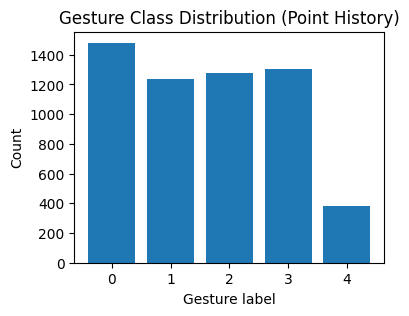

Feature value range across dataset:
Min: -0.925 Max: 0.9125


In [ ]:
# 2.4 Label distribution

labels, counts = np.unique(y_dataset, return_counts=True)

print("Label distribution:")
for label, count in zip(labels, counts):
    print(f"Class {label}: {count} samples")

plt.figure(figsize=(4, 3))
plt.bar(labels, counts)
plt.xticks(labels)
plt.xlabel("Gesture label")
plt.ylabel("Count")
plt.title("Gesture Class Distribution (Point History)")
plt.show()

# Optional: simple range statistics for features (sanity check)
print("Feature value range across dataset:")
print("Min:", X_dataset.min(), "Max:", X_dataset.max())


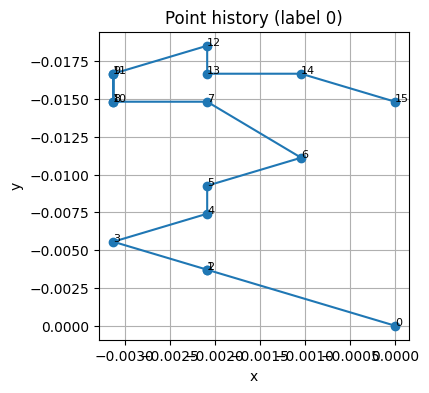

In [ ]:
def plot_point_history(sample, title="Example point history trajectory"):
    """
    Visualise the 2D trajectory of the finger point over TIME_STEPS.
    sample: numpy array of shape (INPUT_DIM,) = (32,)
            [x1, y1, x2, y2, ..., x16, y16]
    """
    assert sample.shape == (INPUT_DIM,)

    points = sample.reshape(TIME_STEPS, DIMENSION)
    xs = points[:, 0]
    ys = points[:, 1]

    plt.figure(figsize=(4, 4))
    # Draw trajectory with arrows/markers
    plt.plot(xs, ys, marker='o')
    for t, (x, y) in enumerate(zip(xs, ys)):
        plt.text(x, y, str(t), fontsize=8)  # annotate time step

    plt.gca().invert_yaxis()  # depending on coordinate system
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

# Plot first sample as an example
plot_point_history(X_dataset[0], title=f"Point history (label {y_dataset[0]})")


## 3. Train/Test Split

We now split the dataset into **training** and **test** sets.

- **Training set**: used to fit the neural network parameters.
- **Test set**: used as **held-out data** to estimate generalisation performance.

Because the dataset is relatively small, we follow the original `point_history_classification` notebook and use **only two splits**:

- 75% training
- 25% testing

> For a production system or larger dataset, a **separate validation set** or **cross-validation** would be preferable, but here we keep things simple and will later discuss this limitation in the report.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset,
    y_dataset,
    train_size=0.75,
    random_state=RANDOM_SEED
    # Note: we follow the original notebook (no stratify argument).
)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Train set size: 4257
Test set size: 1419


## 4. Neural Network for Point History Classification

We implement the **same network architecture** as in the original `point_history_classification` notebook.

The model supports two variants:

1. **MLP (Multilayer Perceptron)** – treats the point history as a flat feature vector.
2. **LSTM-based model** – treats the data as a **time sequence** (shape: 16 × 2) and uses a recurrent layer.

In this assignment, the default is **MLP** (`use_lstm = False`), but you can toggle the flag to compare architectures in experiments.

### 4.1 MLP Architecture (default)

- Input layer: `(TIME_STEPS * DIMENSION,) = (32,)`
- Hidden layers:
  - Dropout(0.2) – regularisation
  - Dense(24 units, ReLU)
  - Dropout(0.5)
  - Dense(10 units, ReLU)
- Output layer:
  - Dense(`NUM_CLASSES`, softmax)

### 4.2 LSTM Architecture (optional)

- Input: sequence of shape `(TIME_STEPS, DIMENSION)` = `(16, 2)`
- Layers:
  - Reshape from (32,) → (16, 2)
  - Dropout(0.2)
  - LSTM(16 units)
  - Dropout(0.5)
  - Dense(10 units, ReLU)
  - Dense(`NUM_CLASSES`, softmax)

You can discuss in your report how **MLP vs LSTM** differ conceptually:

- MLP: fast, simple, treats all features as independent.
- LSTM: can model **temporal dynamics** (order and trajectory), but more complex and data-hungry.


In [ ]:
use_lstm = False  # Set to True if you want to experiment with the LSTM version
model = None

if use_lstm:
    # LSTM-based architecture
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION,)),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    # MLP architecture (default, same as original)
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

model.summary()


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,097 (4.29 KB)

 Trainable params: 1,097 (4.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4.3 Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4.4 Callbacks: ModelCheckpoint & EarlyStopping
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path,
    verbose=1,
    save_weights_only=False  # save full model
)

es_callback = tf.keras.callbacks.EarlyStopping(
    patience=20,
    verbose=1
)


### 4.5 Training Strategy

We train for up to **1000 epochs** with:

- **Batch size** = 128
- **Early stopping** with patience = 20 epochs
- We provide `validation_data=(X_test, y_test)` to monitor performance during training.

> **Important note for the report:**  
> Strictly speaking, the **test set should not be used during training**.  
> Here, to follow the original reference and because the dataset is small, we reuse the test set as "validation" data (for early stopping and learning curves).  
> This may slightly **overestimate** generalisation performance.  
> In your written report, you can mention this as a **methodological limitation** and suggest improvements (e.g. separate train/validation/test).


In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback],
    verbose=1
)


Epoch 1/1000
 1/34 ━━━━━━━━━━━━━━━━━━━━ 24s 755ms/step - accuracy: 0.2266 - loss: 1.6140
Epoch 1: saving model to ../models/point_history\point_history_classifier_20251119_142355.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3899 - loss: 1.5982 - val_accuracy: 0.4496 - val_loss: 1.5729
Epoch 2/1000
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4453 - loss: 1.5823
Epoch 2: saving model to ../models/point_history\point_history_classifier_20251119_142355.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4078 - loss: 1.5666 - val_accuracy: 0.4306 - val_loss: 1.5378
Epoch 3/1000
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4219 - loss: 1.5445
Epoch 3: saving model to ../models/point_history\point_history_classifier_20251119_142355.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3958 - loss: 1.5325 - val_accuracy: 0.4426 - val_loss: 1.4973
Epoch 4/1000
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4090 - loss: 1.5088  
Epoch 4: saving 

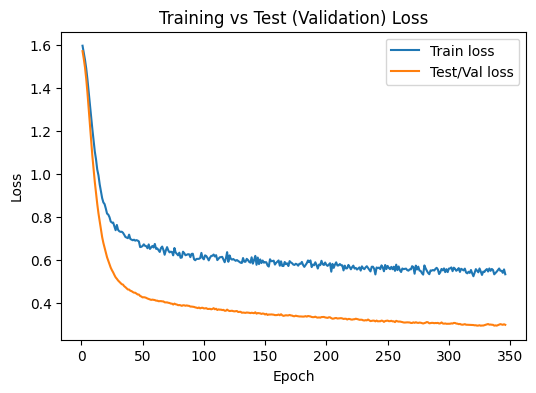

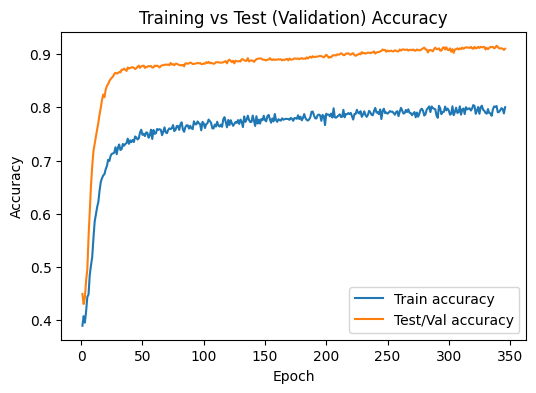

In [ ]:
# 4.6 Visualising Training vs Test (Validation) Curves

train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs_ran = range(1, len(train_loss) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_ran, train_loss, label='Train loss')
plt.plot(epochs_ran, val_loss, label='Test/Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test (Validation) Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs_ran, train_acc, label='Train accuracy')
plt.plot(epochs_ran, val_acc, label='Test/Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Test (Validation) Accuracy')
plt.legend()
plt.show()


In [ ]:
# 4.7 Evaluate the best model on the test set

best_model = tf.keras.models.load_model(model_save_path)

test_loss, test_acc = best_model.evaluate(X_test, y_test, batch_size=128, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


Test loss: 0.2983
Test accuracy: 0.9098


### 4.8 Confusion Matrix & Classification Report

To evaluate model performance beyond a single accuracy number, we compute:

- **Confusion matrix**: shows how predictions are distributed across true classes.
- **Classification report**: precision, recall, F1-score per class.

These metrics are important for:

- Understanding **which gestures are confused** with each other.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


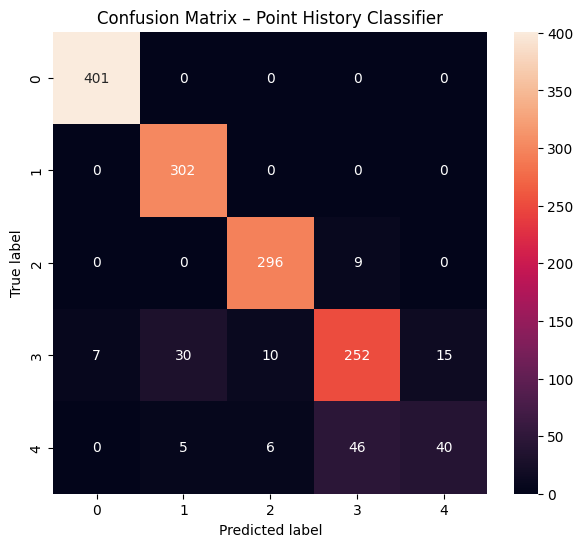

Classification Report
              precision    recall  f1-score   support

           0     0.9828    1.0000    0.9913       401
           1     0.8961    1.0000    0.9452       302
           2     0.9487    0.9705    0.9595       305
           3     0.8208    0.8025    0.8116       314
           4     0.7273    0.4124    0.5263        97

    accuracy                         0.9098      1419
   macro avg     0.8752    0.8371    0.8468      1419
weighted avg     0.9037    0.9098    0.9031      1419



In [ ]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix – Point History Classifier')
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred, digits=4))

# Predict on test set
Y_pred = best_model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)


## 5. Deployment with TensorFlow Lite (TFLite)

In a **real-time Mediapipe application**, we want to run the model efficiently on:

- Laptop / desktop
- Potentially embedded or mobile devices

TensorFlow Lite (TFLite) is suitable for this because it is:

- Lightweight
- Optimised for inference
- Supports quantisation to reduce model size

### Deployment pipeline (high-level):

1. Capture video frames.
2. Use **Mediapipe Hands** to track the fingertip across a short time window (e.g. 16 frames).
3. Construct a 32-dimensional vector `[x1, y1, ..., x16, y16]`.
4. Feed this vector into the **TFLite model**.
5. Interpret the output probabilities and map them to gesture labels.
6. Overlay the recognised gesture on the video stream.

Below we convert the trained model to TFLite and test that it works on a sample input.


In [ ]:
# Ensure we are converting the best model (from checkpoint)
best_model.save(model_save_path, include_optimizer=False)

# TFLite conversion with default optimisations (e.g., quantisation)
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

print("Saved TFLite model to:", tflite_save_path)


INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmph802lhst\assets


INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmph802lhst\assets


Saved artifact at 'C:\Users\brian\AppData\Local\Temp\tmph802lhst'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1972122481872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1972122481104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1972122482256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1972122484368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1972122479568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1972122482832: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved TFLite model to: ../models/point_history\point_history_classifier_20251119_142355.tflite


In [ ]:
# Test the TFLite model on one sample

interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("TFLite input details:", input_details)
print("TFLite output details:", output_details)

sample = X_test[0:1].astype(np.float32)
true_label = y_test[0]

interpreter.set_tensor(input_details[0]['index'], sample)
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print("TFLite raw output probabilities:", np.squeeze(tflite_results))
print("TFLite predicted class:", int(np.argmax(tflite_results)))
print("True class:", int(true_label))


TFLite input details: [{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
TFLite output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 10, 'shape': array([1, 5]), 'shape_signature': array([-1,  5]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
TFLite raw output probabilities: [0.940536   0.02072478 0.01461299 0.02295544 0.00117074]
TFLite predicted class: 0
True class: 0


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
